---
title: sonar
---

## Implémentation de classifieurs binaires 

### Imports

In [ ]:
from joblib import parallel_backend
parallel_backend("loky", n_jobs=-1)

In [ ]:
import sys
sys.path.append("./../src/")

from get_dataset import dataset_loaders
dataset = list(dataset_loaders.keys())[0]

In [ ]:
# Parameters
dataset = "sonar"


In [76]:
from get_dataset import load_dataset

X, y = load_dataset(dataset)

### Data presentation

**{eval}`dataset`\** dataset contains `n` = {eval}`X.shape[0]` samples and `p` = {eval}`X.shape[1]` features.

The target variable is binary and {}`y.mean() * 100:.2f`% of the samples are positive.

In [77]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Normalize data using only the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Prepare model results storage

In [78]:
MODELS = dict()

def store_results(name, grid):
    MODELS[name] = {
        "best_params": grid.best_params_,
        "X_test": X_test,
        "y_true": y_test,
        "y_pred": grid.predict(X_test),
        "y_proba": grid.predict_proba(X_test)
    }
     
    pass

### Entraînement des classifieurs

#### Classifieurs non paramétriques

##### K-Nearest Neighbors

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
    )

grid_search.fit(X_train, y_train)
store_results('KNN', grid_search)

##### Distance-Weighted KNN

In [80]:
model = KNeighborsClassifier(weights='distance', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
    )

grid_search.fit(X_train, y_train)
store_results('KNN Distance Weighted', grid_search)

##### Condensed Nearest Neighbor

In [81]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import validate_data

# Wrap CondensedNearestNeighbour into an sklearn compatible transformer for use in pipelines
class CondensedNearestNeighbourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy = "auto", random_state = 42, n_neighbors = None, n_seeds_S = 1):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.n_neighbors = n_neighbors
        self.n_seeds_S = n_seeds_S

    def fit(self, X, y=None):
        # validate_data(X, y, accept_sparse=True, reset=True)
        self.n_features_in_ = X.shape[1]
        
        return self

    def transform(self, X, y=None):
        # check_X_y(X, y)

        if y is None:
            return X
        else:    
          return CondensedNearestNeighbour(
            sampling_strategy = self.sampling_strategy,
            random_state = self.random_state,
            n_neighbors = self.n_neighbors,
            n_seeds_S = self.n_seeds_S
          ).fit_resample(X, y)

from sklearn.utils.estimator_checks import check_estimator
# check_estimator(CondensedNearestNeighbourTransformer())

In [82]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('cnn', CondensedNearestNeighbourTransformer(sampling_strategy='auto', n_neighbors=3, n_seeds_S=1)),
    ('knn', KNeighborsClassifier(weights='uniform', algorithm='auto'))
])

param_grid = {
    'cnn__n_neighbors': [3, 5, 7, 9],
    'knn__n_neighbors': [3, 5, 7, 9],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
    )

grid_search.fit(X_train, y_train)
store_results('KNN Condensed Nearest Neighbor', grid_search)

##### Locally Adaptive KNN

In [83]:
class LocallyAdaptiveKNN(KNeighborsClassifier):
    def predict(self, X):
        distances, indices = self.kneighbors(X)
        predictions = []
        for i, neighbors in enumerate(indices):
            local_k = int(len(neighbors) / 2)  # Example of adapting k locally
            local_knn = KNeighborsClassifier(n_neighbors=local_k)
            local_knn.fit(self._fit_X[neighbors], self._y[neighbors])
            predictions.append(local_knn.predict([X[i]])[0])
        return predictions

model = LocallyAdaptiveKNN(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
    )

grid_search.fit(X_train, y_train)
store_results('KNN Locally Adaptive', grid_search)

#### Classifieurs binaires non linéaires

##### Arbre de décision (Decision Tree)

In [84]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('Decision Tree', grid_search)

##### Forêt aléatoire (RandomForest)

In [85]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight=None)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('Random Forest', grid_search)

##### Forêt aléatoire avec cost-sensitive learning

In [86]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('Random Forest - cost-sensitive learning', grid_search)

##### AdaBoost

In [87]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('AdaBoost', grid_search)

##### Gradient Boosting

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('Gradient Boosting', grid_search)

#### Classifieurs binaires paramétriques

##### SVM Linéaire

In [89]:
from sklearn.svm import SVC

model = SVC(
    kernel='linear',
    random_state=42, probability=True)

param_grid = {
    'C': [0.1, 0.5, 1],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('SVM', grid_search)

##### SVM  non linéaire

In [90]:
from sklearn.svm import SVC

model = SVC(random_state=42, probability=True)

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire', grid_search)

##### SVM non linéaire avec sur-échantillonnage

In [91]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

model = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)),
    ('svm', SVC(random_state=42, probability=True))
])

param_grid = {
    'svm__kernel': ['poly', 'rbf', 'sigmoid'],
    'svm__C': [0.1, 0.5, 1],
    'svm__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire avec SMOTE', grid_search)

##### SVM avec cost-sensitive learning (ajustement pénalité C)

In [92]:
from sklearn.svm import SVC

# Define the model with class_weight set to 'balanced' to adjust C depending on class
model = SVC(random_state=42, probability=True, class_weight='balanced')

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('SVM cost-sensitive learning', grid_search)

##### Régression logistique

In [93]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, solver='liblinear', dual=False)

param_grid = {
    'C': [0.1, 0.5, 1],                         # Inverse de la force de régularisation
    'penalty': ['l1', 'l2'],      # Type de régularisation
    'class_weight': [None, 'balanced']          # Poids des classes
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    refit=True
)

grid_search.fit(X_train, y_train)
store_results('Logistic Regression', grid_search)

/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


#### Sauvegarde des prédictions et paramètres des modèles

In [99]:
from pathlib import Path
from joblib import dump

# Save models results
dump(MODELS, f"./../results/{dataset}.joblib")

['./../results/abalone8.joblib']

#### Performance des modèles sur les données de test

Model: KNN


,precision,recall,f1-score,support
ham,88.18%,97.16%,92.45%,1090
spam,41.51%,13.41%,20.28%,164
accuracy,,,86.20%,1254
macro avg,64.84%,55.29%,56.36%,1254
weighted avg,82.07%,86.20%,83.01%,1254


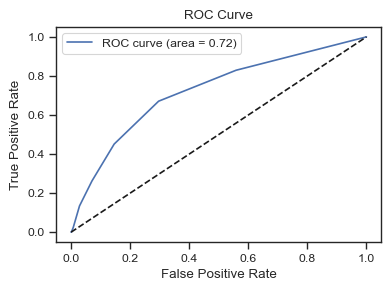

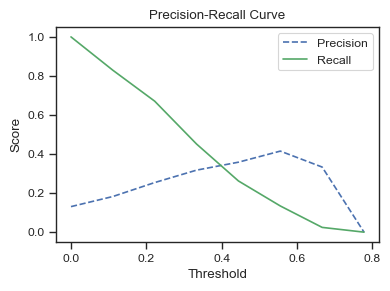

Model: KNN Distance Weighted


,precision,recall,f1-score,support
ham,88.08%,96.97%,92.31%,1090
spam,38.89%,12.80%,19.27%,164
accuracy,,,85.96%,1254
macro avg,63.49%,54.89%,55.79%,1254
weighted avg,81.65%,85.96%,82.76%,1254


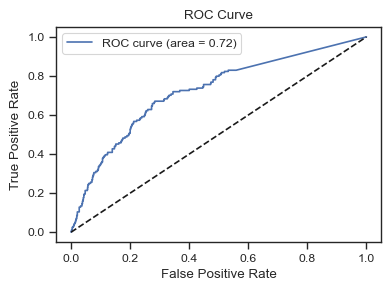

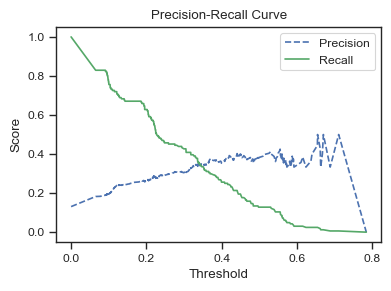

Model: KNN Condensed Nearest Neighbor


,precision,recall,f1-score,support
ham,88.18%,97.16%,92.45%,1090
spam,41.51%,13.41%,20.28%,164
accuracy,,,86.20%,1254
macro avg,64.84%,55.29%,56.36%,1254
weighted avg,82.07%,86.20%,83.01%,1254


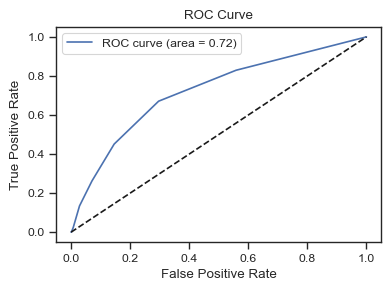

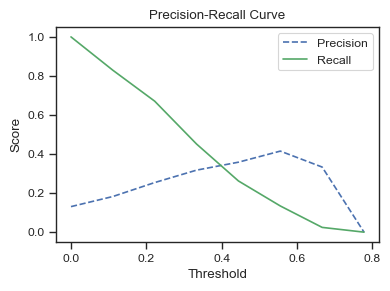

Model: KNN Locally Adaptive


,precision,recall,f1-score,support
ham,88.01%,97.61%,92.56%,1090
spam,42.22%,11.59%,18.18%,164
accuracy,,,86.36%,1254
macro avg,65.11%,54.60%,55.37%,1254
weighted avg,82.02%,86.36%,82.83%,1254


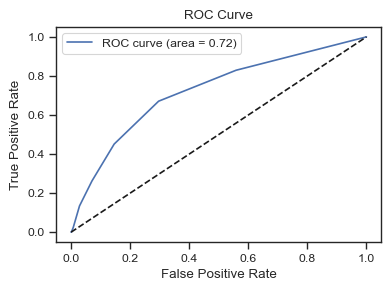

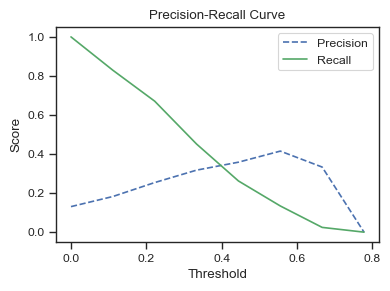

Model: Decision Tree


,precision,recall,f1-score,support
ham,86.97%,99.82%,92.95%,1090
spam,33.33%,0.61%,1.20%,164
accuracy,,,86.84%,1254
macro avg,60.15%,50.21%,47.07%,1254
weighted avg,79.96%,86.84%,80.95%,1254


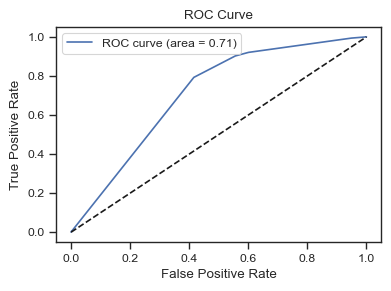

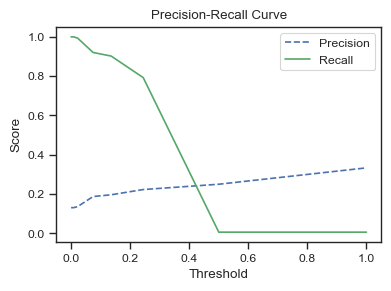

Model: Random Forest


,precision,recall,f1-score,support
ham,86.91%,99.91%,92.96%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.84%,1254
macro avg,43.46%,49.95%,46.48%,1254
weighted avg,75.55%,86.84%,80.80%,1254


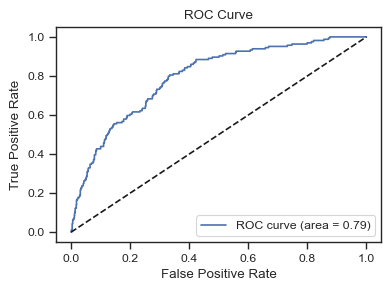

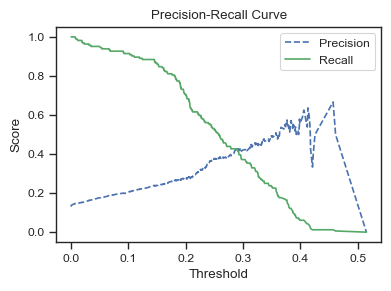

Model: Random Forest - cost-sensitive learning


,precision,recall,f1-score,support
ham,93.56%,74.68%,83.06%,1090
spam,28.12%,65.85%,39.42%,164
accuracy,,,73.52%,1254
macro avg,60.84%,70.27%,61.24%,1254
weighted avg,85.01%,73.52%,77.35%,1254


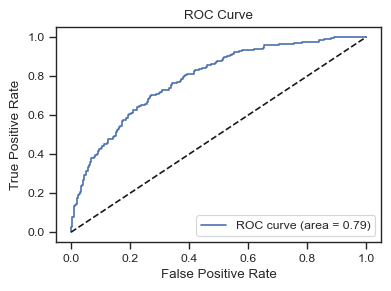

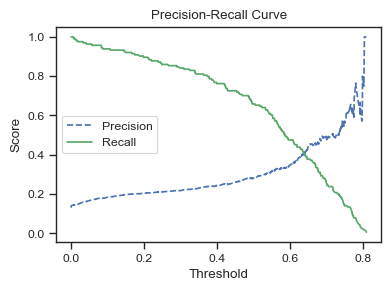

Model: AdaBoost


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

,precision,recall,f1-score,support
ham,86.92%,100.00%,93.00%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.92%,1254
macro avg,43.46%,50.00%,46.50%,1254
weighted avg,75.55%,86.92%,80.84%,1254


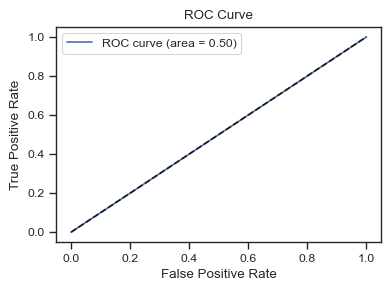

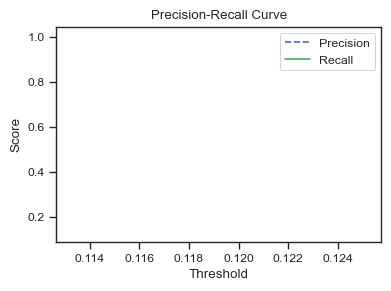

Model: Gradient Boosting


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

,precision,recall,f1-score,support
ham,86.92%,100.00%,93.00%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.92%,1254
macro avg,43.46%,50.00%,46.50%,1254
weighted avg,75.55%,86.92%,80.84%,1254


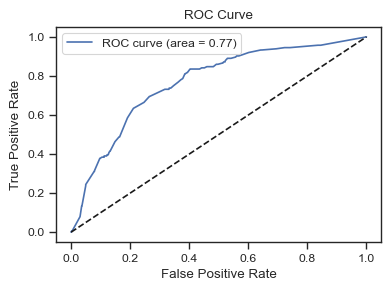

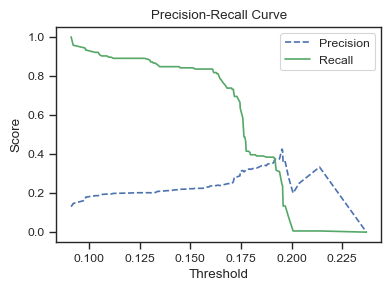

Model: SVM


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

,precision,recall,f1-score,support
ham,86.92%,100.00%,93.00%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.92%,1254
macro avg,43.46%,50.00%,46.50%,1254
weighted avg,75.55%,86.92%,80.84%,1254


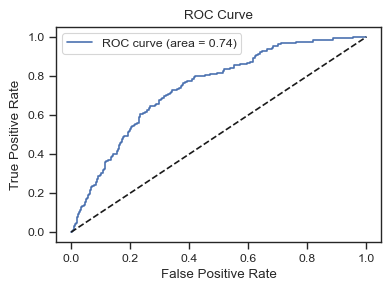

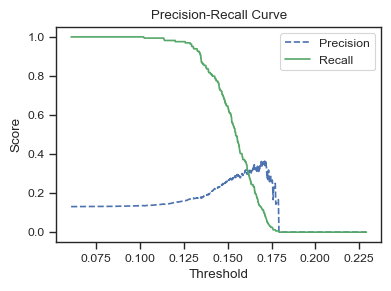

Model: SVM non linéaire


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

,precision,recall,f1-score,support
ham,86.92%,100.00%,93.00%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.92%,1254
macro avg,43.46%,50.00%,46.50%,1254
weighted avg,75.55%,86.92%,80.84%,1254


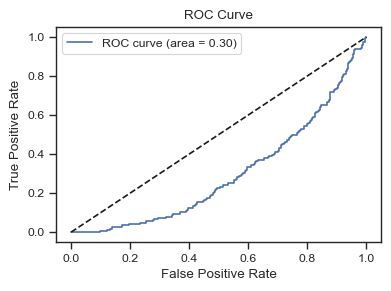

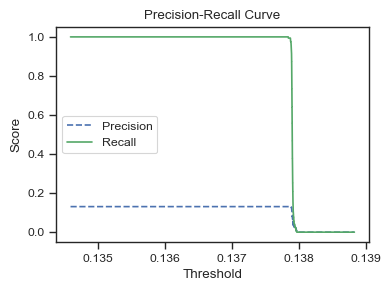

Model: SVM non linéaire avec SMOTE


,precision,recall,f1-score,support
ham,94.89%,56.24%,70.62%,1090
spam,21.55%,79.88%,33.94%,164
accuracy,,,59.33%,1254
macro avg,58.22%,68.06%,52.28%,1254
weighted avg,85.30%,59.33%,65.82%,1254


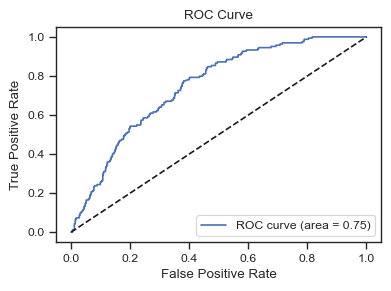

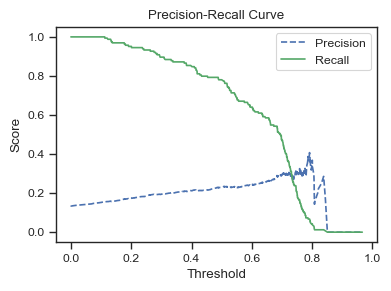

Model: SVM cost-sensitive learning


,precision,recall,f1-score,support
ham,94.76%,58.07%,72.01%,1090
spam,22.01%,78.66%,34.40%,164
accuracy,,,60.77%,1254
macro avg,58.39%,68.37%,53.21%,1254
weighted avg,85.25%,60.77%,67.09%,1254


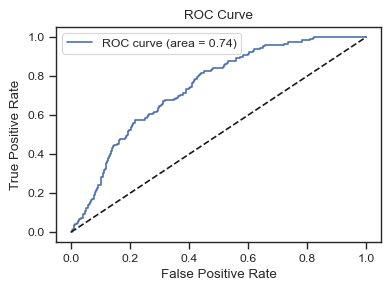

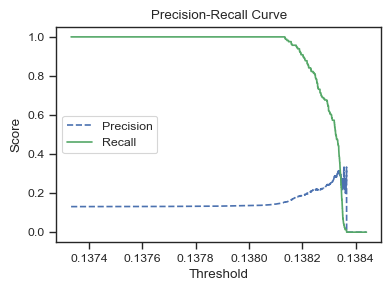

Model: Logistic Regression


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

,precision,recall,f1-score,support
ham,86.92%,100.00%,93.00%,1090
spam,0.00%,0.00%,0.00%,164
accuracy,,,86.92%,1254
macro avg,43.46%,50.00%,46.50%,1254
weighted avg,75.55%,86.92%,80.84%,1254


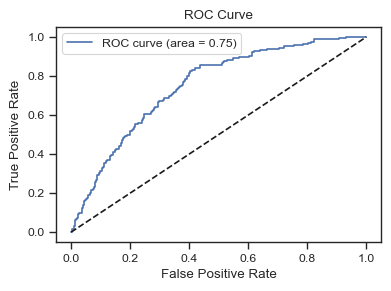

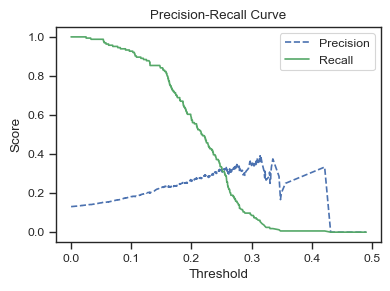

In [116]:
from utils import plot_roc, plot_precision_recall, table_report

for model_name, model in MODELS.items():
    print(f"Model: {model_name}")
    table_report(model['y_true'], model['y_pred'])
    plot_roc(model['y_true'], model['y_proba'][:, 1])
    plot_precision_recall(model['y_true'], model['y_proba'][:, 1])